# Importation des bibliothèques et Chargement des fichiers 

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [44]:
# Chargement du fichier CSV pour explorer sa structure
csv_path = "/Users/oseeibobi/Documents/Study/Master/M2/DeepLearning/Project_Alzheimer/archive-2/train.csv"
df = pd.read_csv(csv_path)



In [45]:
# Aperçu des premières lignes
df.head()

,id_code,diagnosis
0,AD-3471,4
1,CN-1819,0
2,LMCI-0760,3
3,LMCI-1810,3
4,CN-4049,0


# Dimension du Dataset

In [46]:
print("train_shape:", df.shape)

train_shape: (20257, 2)


# Les différentes étiquettes du fichier train_csv
0: CN (Cognitivement normal)
1: MCI (déficience cognitive légée)
2: EMCI (déficience cognitive légère précoce)
3: LMCI (Téficience Cognitive Légère tardive)
4: AD (maladie d'Alzheimer)

In [51]:
# Mapping étiquettes
label_map = {
    0: "CN",     # Cognitivement normal
    1: "EMCI",   # déficience cognitive légère précoce
    2: "MCI",    # Déficience cognitive légée
    3: "LMCI",   # Téficience Cognitive légère tardive
    4: "AD"      # maladie d'Alzheimer
}


In [52]:
df["label_str"] = df["diagnosis"].map(label_map)

df.head(5)

,id_code,diagnosis,label_str
0,AD-3471,4,AD
1,CN-1819,0,CN
2,LMCI-0760,3,LMCI
3,LMCI-1810,3,LMCI
4,CN-4049,0,CN


In [53]:
# Afficher les noms de colonnes disponibles
print("Colonnes disponibles dans le CSV :", df.columns.tolist())

Colonnes disponibles dans le CSV : ['id_code', 'diagnosis', 'label_str']


id_code: pour construire le chemin des fichiers image (.png)
diagnosis: pour les labels numériques
label_str: pour la visualisation

# Distribution de chaque classe  et Description du Dataset 

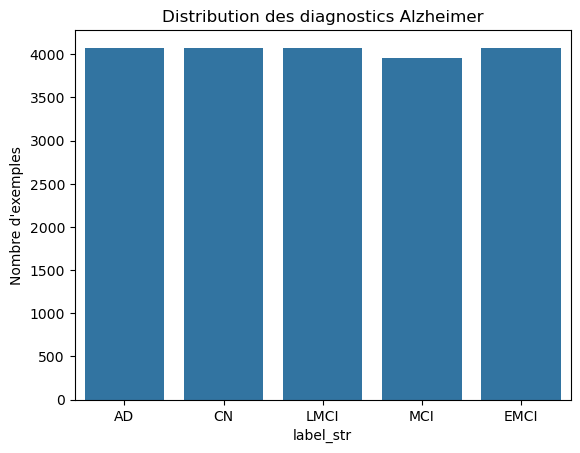

In [54]:
# Distribution des classes
sns.countplot(data=df, x="label_str")
plt.title("Distribution des diagnostics Alzheimer")
plt.ylabel("Nombre d'exemples")
plt.show()

In [55]:
df.describe()

,diagnosis
count,20257.000000
mean,1.999852
std,1.418449
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


# Préparation des données pour TensorFlow
TensorFlow permet de créer, entraîner, tester et déployer des modèles d’intelligence artificielle.

In [56]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Ici ImageDataGenerator me permet de: 
-Normaliser les images, 
-Créer un split entraînement/validation,
-Appliquer de l’augmentation de données

In [57]:
#Dossier pour l'extraction des images
base_dir = "/Users/oseeibobi/Documents/Study/Master/M2/DeepLearning/Project_Alzheimer/archive-2/ADNI_IMAGES/png_images" 

#Construction du chemin d'accès complet pour chaque image (en supposant .png)
df["filepath"] = df.apply(lambda row: os.path.join(base_dir, row["label_str"], f"{row['id_code']}.png"), axis=1)
df["label"] = df["diagnosis"].astype(str)


In [58]:
# Affiche quelques noms de fichiers PNG
images = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(".png"):
            images.append(os.path.join(root, file))

print(f"{len(images)} images trouvées.")
print("Exemple :", images[:3])

20257 images trouvées.
Exemple : ['/Users/oseeibobi/Documents/Study/Master/M2/DeepLearning/Project_Alzheimer/archive-2/ADNI_IMAGES/png_images/AD/AD-0366.png', '/Users/oseeibobi/Documents/Study/Master/M2/DeepLearning/Project_Alzheimer/archive-2/ADNI_IMAGES/png_images/AD/AD-1078.png', '/Users/oseeibobi/Documents/Study/Master/M2/DeepLearning/Project_Alzheimer/archive-2/ADNI_IMAGES/png_images/AD/AD-2571.png']


In [59]:
# On va chercher dynamiquement les fichiers dans chaque sous-dossier label_str
from glob import glob

filepaths = [] #Chemins complets vers les images.

labels = [] #Stocke les labels (0 à 4) associés à chaque image

for label in df['label_str'].unique():#On parcours chaque nom de classe unique
    folder = os.path.join(base_dir, label)
    paths = glob(os.path.join(folder, "*.png"))
    filepaths.extend(paths)
    labels.extend([k for k, v in label_map.items() if v == label][0] for _ in range(len(paths)))  # on mappe vers la valeur numérique

# Reconstruction du dataframe avec chemins d'accès valides
filepath_df = pd.DataFrame({"filepath": filepaths, "diagnosis": labels})
filepath_df["label"] = filepath_df["diagnosis"].astype(str)
df = filepath_df.copy()
df["label"] = df["diagnosis"].astype(str)


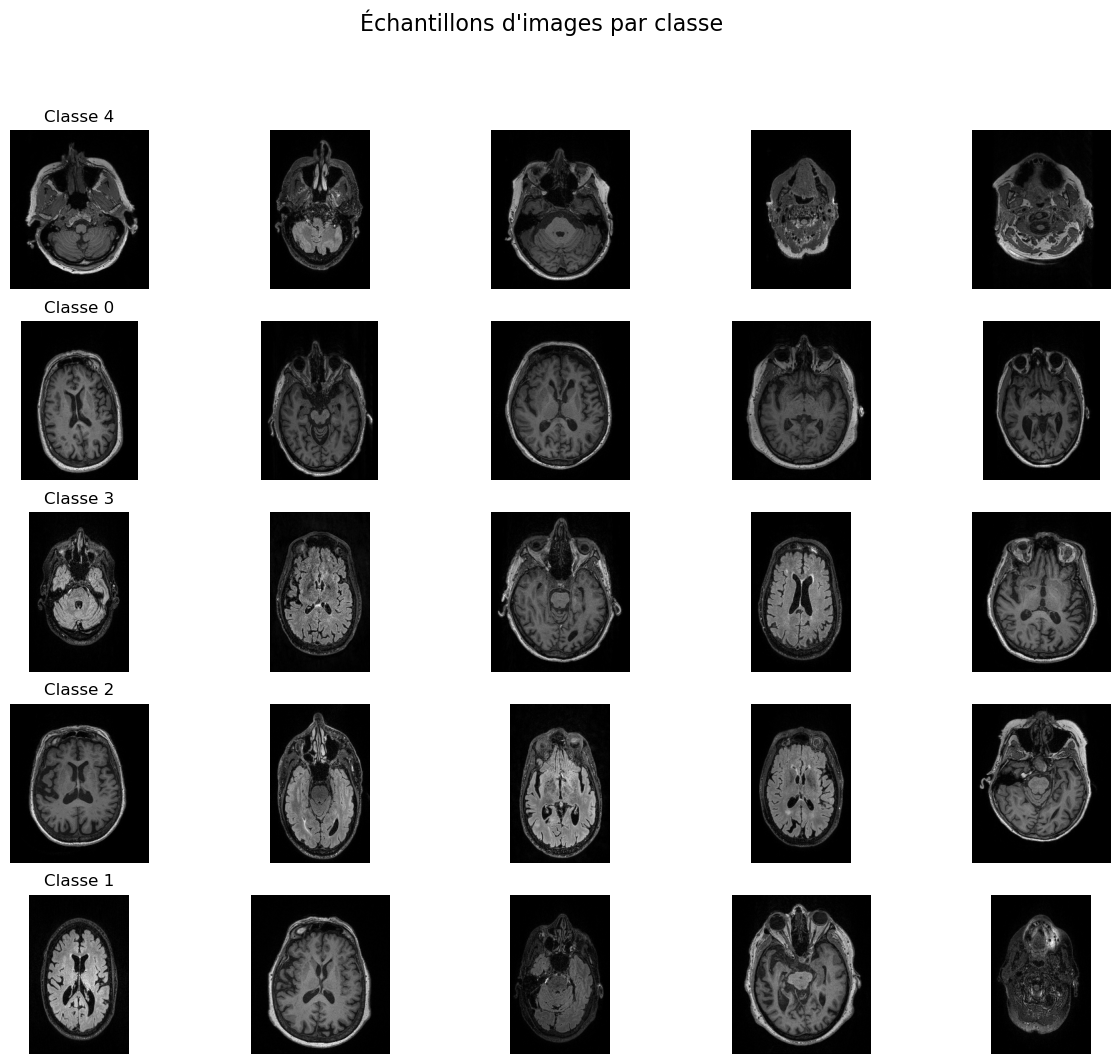

In [ ]:
#Affichage de quelques images par classe pour vérification
import matplotlib.image as mpimg

fig, axes = plt.subplots(5, 5, figsize=(15, 12))
fig.suptitle("Échantillons d'images par classe", fontsize=16)

# Classes à afficher (maximum 5 classes, 5 images chacune)
classes_to_show = df["label"].unique()
for i, label in enumerate(classes_to_show):
    samples = df[df["label"] == label].sample(5, random_state=42)
    for j, img_path in enumerate(samples["filepath"]):
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f"Classe {label}")

# L'Augmentation des données
L'augmentation des données (data augmentation) est une technique qui consiste à générer des variations artificielles à partir des images existantes,
afin d'augmenter la diversité des données d'entraînement (Ça permet au modèle d’apprendre à mieux généraliser à des cas qu’il n’a pas vus). Cela aide à rendre le modèle plus robuste et à éviter le surapprentissage (overfitting).
Exemples : rotation(Apprend à reconnaître une IRM même si elle est inclinée), zoom(Apprend à voir les détails à différentes échelles), retournement horizontal(Simule une image inversée (utile si le cerveau est symétrique)), etc.

In [60]:
# Générateur d'images avec augmentation
img_size = (224, 224) # Redimension des images à 224x224 pixels
batch_size = 32 # Nombre d'images par entrainement 

datagen = ImageDataGenerator(
    rescale=1./255, #Les pixels sont normalisés entre 0 et 1 au lieu de 0 à 255
    validation_split=0.2, #20% pour les données de validations
    rotation_range=15, #Les images sont retournées jusqu'à 15 degré
    zoom_range=0.1, #Zoom jusqu'à 10%
    horizontal_flip=True #Retourne l'image  horizentalement de manière aléatoire
)

#dataframe contenant chemin+label
train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="filepath",#Chemin de chaque image
    y_col="label",#Classe associée à chaque image
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",#Car on a plusieurs classes (0 à 4)
    subset="training",#80% pour l'entrainement
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",#20% restant 
    shuffle=True
)

Found 16206 validated image filenames belonging to 5 classes.
Found 4051 validated image filenames belonging to 5 classes.


16206 images ont été trouvées et utilisées pour l'entraînement (80% du total) et 4051 images pour la validation (20%)

# Création d'un modèle CNN Personnalisé
Le CNN personnalisé est conçu pour apprendre à classifier les images IRM cérébrales sans connaissance préalable. Il sert de point de comparaison aux modèles utilisant le Transfert Learning, et permet d’évaluer dans quelle mesure un réseau entraîné de zéro est capable d’atteindre des performances similaires ou inférieures à celles de modèles pré-entraînés sur ImageNet. 

In [61]:
from tensorflow.keras import layers, models

In [ ]:
model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 classes
])

#model_cnn = models.Sequential([
    #layers.Input(shape=(224, 224, 3)),
    #layers.Conv2D(32, (3,3), activation='relu'),
    #layers.MaxPooling2D(2, 2),
    #layers.Conv2D(64, (3,3), activation='relu'),
    #layers.MaxPooling2D(2, 2),
    #layers.Conv2D(128, (3,3), activation='relu'),
    #layers.MaxPooling2D(2, 2),
    #layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),
    #layers.Dense(5, activation='softmax')  # 5 classes
#])


model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Entrainement du CNN

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 248s 487ms/step - accuracy: 0.4112 - loss: 1.3014 - val_accuracy: 0.0000e+00 - val_loss: 6.6265
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 293s 577ms/step - accuracy: 0.6767 - loss: 0.8053 - val_accuracy: 0.0000e+00 - val_loss: 5.8894
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 328s 646ms/step - accuracy: 0.7319 - loss: 0.6872 - val_accuracy: 0.0000e+00 - val_loss: 9.2669
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 335s 661ms/step - accuracy: 0.7813 - loss: 0.5619 - val_accuracy: 0.0000e+00 - val_loss: 8.0887
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 372s 733ms/step - accuracy: 0.8143 - loss: 0.4800 - val_accuracy: 0.0000e+00 - val_loss: 8.8344
Epoch 6/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 350s 690ms/step - accuracy: 0.8332 - loss: 0.4412 - val_accuracy: 0.0000e+00 - val_loss: 8.5020
Epoch 7/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 352s 695ms/step - accuracy: 0.8542 - loss: 0.3822 - val_accuracy: 0.0000e+00 - val_loss: 8.0833
Epoch 8/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 363s 716

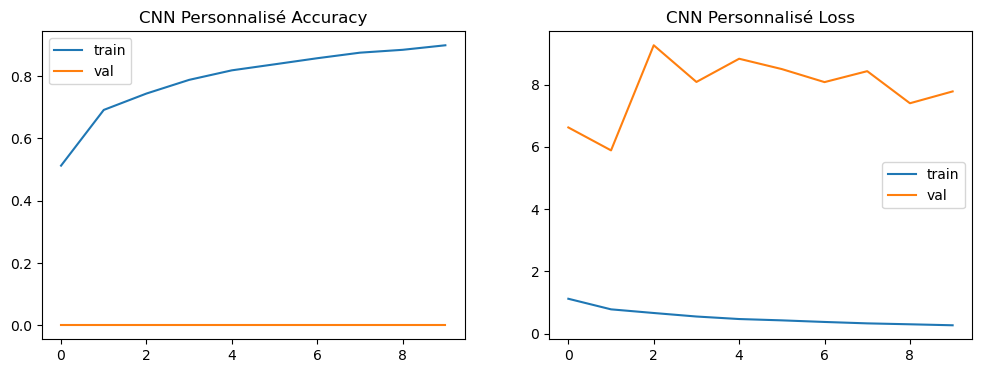

In [64]:
# 📊 Entraînement du CNN
history_cnn = model_cnn.fit(train_gen, validation_data=val_gen, epochs=10)

# 📊 Fonction pour tracer les performances
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

plot_history(history_cnn, "CNN Personnalisé")

# Transfert Learning avec MobileNetV2

In [67]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model


In [69]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(5, activation='softmax')(x)

model_mobilenet = Model(inputs=base_model.input, outputs=out)
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [70]:
#Entraînement du modèle MobileNetV2
history_mobilenet = model_mobilenet.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 160s 312ms/step - accuracy: 0.4298 - loss: 1.3133 - val_accuracy: 0.0000e+00 - val_loss: 6.3034
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 201s 396ms/step - accuracy: 0.6345 - loss: 0.9024 - val_accuracy: 0.0000e+00 - val_loss: 7.2392
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 196s 386ms/step - accuracy: 0.6971 - loss: 0.7687 - val_accuracy: 0.0000e+00 - val_loss: 7.6836
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 194s 383ms/step - accuracy: 0.7362 - loss: 0.6742 - val_accuracy: 0.0000e+00 - val_loss: 6.5189
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 197s 388ms/step - accuracy: 0.7662 - loss: 0.6083 - val_accuracy: 0.0000e+00 - val_loss: 6.4220
Epoch 6/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 202s 399ms/step - accuracy: 0.7829 - loss: 0.5690 - val_accuracy: 0.0000e+00 - val_loss: 6.1589
Epoch 7/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 194s 383ms/step - accuracy: 0.8007 - loss: 0.5208 - val_accuracy: 0.0000e+00 - val_loss: 6.9800
Epoch 8/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 192s 379

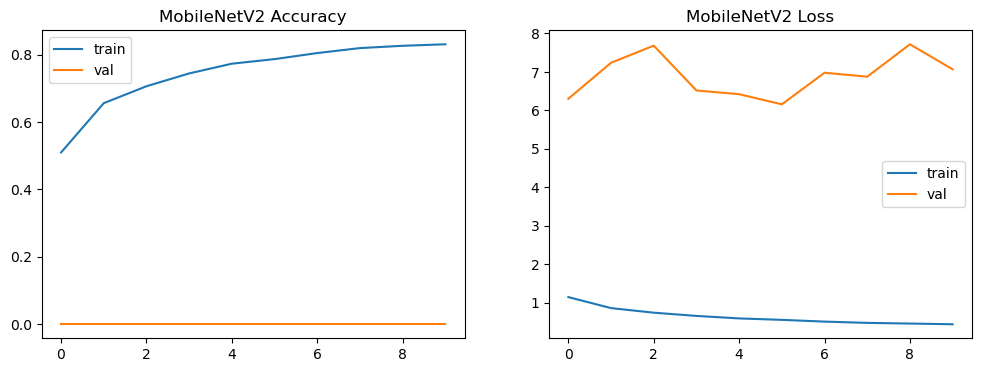

In [71]:
#Affichage des courbes
plot_history(history_mobilenet, "MobileNetV2")

# Transfert Learning avec EfficientNetB0

In [72]:
from tensorflow.keras.applications import EfficientNetB0

In [73]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(5, activation='softmax')(x)

model_effnet = Model(inputs=base_model.input, outputs=out)
model_effnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_effnet.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [74]:
#Entraînement
history_effnet = model_effnet.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 294s 574ms/step - accuracy: 0.2451 - loss: 1.4337 - val_accuracy: 0.0000e+00 - val_loss: 5.7870
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 296s 584ms/step - accuracy: 0.2463 - loss: 1.4012 - val_accuracy: 0.0000e+00 - val_loss: 7.7577
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 286s 563ms/step - accuracy: 0.2457 - loss: 1.4002 - val_accuracy: 0.0000e+00 - val_loss: 8.6041
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 287s 566ms/step - accuracy: 0.2493 - loss: 1.3999 - val_accuracy: 0.0000e+00 - val_loss: 8.5777
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 282s 557ms/step - accuracy: 0.2521 - loss: 1.4036 - val_accuracy: 0.0000e+00 - val_loss: 6.6165
Epoch 6/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 278s 547ms/step - accuracy: 0.2492 - loss: 1.3962 - val_accuracy: 0.0000e+00 - val_loss: 7.2220
Epoch 7/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 281s 553ms/step - accuracy: 0.2547 - loss: 1.3986 - val_accuracy: 0.0000e+00 - val_loss: 5.1691
Epoch 8/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 282s 556

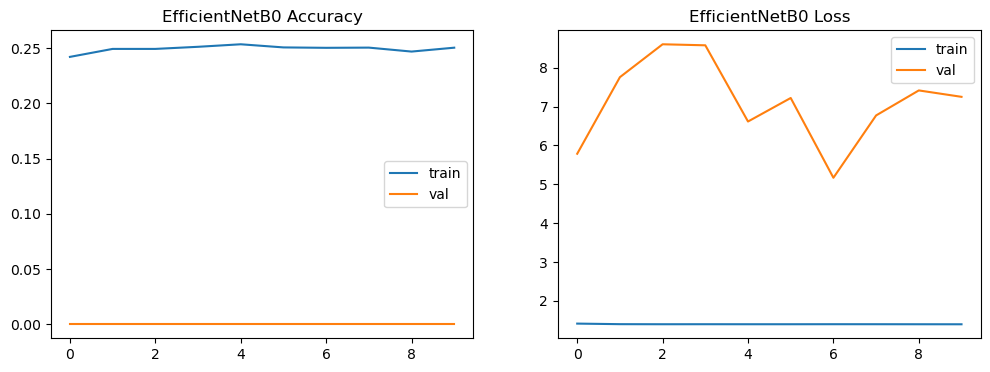

In [75]:
#Affichage des courbes
plot_history(history_effnet, "EfficientNetB0")


# Comparaison des Modèles

Modèle	Précision entraînement	Précision validation	Temps d’entraînement (par epoch)	Remarque principale
CNN personnalisé	89.5%	0%	5-6 minutes	Bon apprentissage mais pas généralisé
MobileNetV2	82.8%	0%	3 minutes	Léger et rapide mais surapprend
EfficientNetB0	25%	0%	5 minutes	Ne parvient pas à apprendre correctement
